In [268]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import numpy as np
import missingno as msno
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

params = {'figure.constrained_layout.use': False,
          'axes.facecolor': 'gainsboro',
          'axes.grid': True,
          'grid.linestyle': '--',
          'axes.labelsize': 12,
          'axes.titlesize': 14,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12}
plt.rcParams.update(params)
%matplotlib inline

In [216]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

In [217]:
warnings.simplefilter("ignore")

# Содержание<a name="1"></a>

1. [Предобработка](#2)
2. [Первичный осмотр данных](#3)
3. [Анализ и очистка переменных](#4)
4. [Создание новых признаков](#5)
5. [Начальная обработка](#6)
6. [Визуализация](#7)
7. [Feature Engineering](#8)
8. [Поиск выбросов](#9)

---

# 1. Предобработка<a name="2"></a>

In [218]:
RANDOM_SEED = 42

In [219]:
def mm_scaler(df, column):
    scl = MinMaxScaler()
    col = np.column_stack(df[column])
    col = np.reshape(col, (col.shape[1],1))
    return scl.fit_transform(col)

In [220]:
def get_jointplot(df, col_x, col_y):
    '''Функция для вывода графика регрессии и корреляции'''
    corr = round(df[[col_x, col_y]].corr().values[0][1], 2)
    sns.jointplot(x=col_x, y=col_y, 
                  data=df, 
                  kind='reg', 
                  color='xkcd:darkish blue')
    print('----------------')
    print(f'Корреляция: {corr}')
    print('----------------')

In [267]:
def get_countplot(df, column):
    col = df[column].value_counts().sort_values(ascending=False)
    plt.figure(figsize=(12, 7), dpi=100)
    sns.countplot(df[column], order=col.index,
                  palette='Blues_r',
                  edgecolor='k',
                  linewidth=2)
    plt.xticks(rotation='vertical')
    plt.title(f'Распределение признака {column}', fontsize=15)
    plt.ylabel('Количество')
    for i, value in enumerate(col.values):  # Количество значений
        plt.text(i, value-1, value,
                 horizontalalignment='right',
                 fontsize=10,
                 rotation='vertical',
                 bbox={'facecolor': 'w'})
    return df[column].describe()

In [222]:
def get_countplot_top_ten(df, column):
    col = df[column].value_counts().sort_values(ascending=False)[:10]
    plt.figure(figsize=(12, 7), dpi=100)
    sns.countplot(df[column], order=col.index,
                  palette='Blues_r',
                  edgecolor='k',
                  linewidth=2)
    plt.xticks(rotation='vertical')
    plt.title(f'Распределение признака {column}', fontsize=15)
    plt.ylabel('Количество')
    for i, value in enumerate(col.values):  # Количество значений
        plt.text(i, value-1, value,
                 horizontalalignment='right',
                 fontsize=10,
                 rotation='vertical',
                 bbox={'facecolor': 'w'})

In [265]:
def get_histogram(df, column):
    col = df[column]
    counts, bins = np.histogram(col.dropna())
    plt.figure(figsize=(12, 7), dpi=100)
    plt.hist(bins[:-1],  bins,
            weights=counts,
            color='steelblue',
            edgecolor='k',
            linewidth=2)
    plt.title(f'Распределение признака {column}')
    plt.axvline(col.median(), color='w',
               linestyle='--', linewidth=3)
    plt.axvline(col.mean(), color='k',
               linestyle='--', linewidth=3)
    plt.text(col.mean()*1.01, max(counts)*0.9, # Среднее
            f'Mean: {round(col.mean(), 2)}', 
            color='w',fontsize=10, 
            bbox={'facecolor': 'k'})
    plt.text(col.median()*1.01, max(counts)*0.8, # Медиана
            f'Median: {round(col.median(), 2)}',
            fontsize=10, bbox={'facecolor': 'w', 
                               'edgecolor': 'w'})
    return df[column].describe()

In [224]:
def get_distplot(df, column):
    plt.figure(figsize=(12, 7), dpi=100)
    sns.distplot(df[column], bins=100, 
                 kde_kws={"color": "k", "lw": 3, "label": "KDE"}, 
                 hist_kws={"histtype": "bar", 
                           "color": 'steelblue', 
                           "edgecolor": 'k', 
                           "linewidth": 1, "alpha": 1})
    plt.ylabel('Плотность распределения')

In [225]:
def get_value_histogram_top_ten(df, col_x, col_y):
    plt.figure(figsize=(12, 7), dpi=100)
    colors = [plt.cm.Blues_r(i/float(10-1)) for i in range(10)]
    for i, y in enumerate(df[col_y].value_counts()[0:10].index):
        df[col_x][df[col_y] == y].hist(bins=20, label=y, 
                                       color=colors[i], 
                                       edgecolor='k', 
                                       linewidth=2)

    plt.legend(prop={'size': 10})
    plt.title(f'Распределение {col_x} по {col_y}', fontsize=15)
    plt.xlabel(col_x)
    plt.ylabel('Количество')

In [263]:
def first_look(df,column):
    if df[column].dtype == 'O':
        return get_countplot(df,column)
    else:
        return get_histogram(df,column)

In [227]:
def get_stat_dif(df, col_x, col_y):
    '''Функция для теста Стьюдента.
    
    Возвращает текст, если найдены
    статистически значимые различия.
    '''
    cols = df[col_x].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df[col_x] == comb[0], col_y],
                     df.loc[df[col_x] == comb[1], col_y]).pvalue \
                     <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            return 'ttest: значимые различия'
            break
    return 'ttest: различия не найдены'

In [228]:
def get_anova(df, col_x, col_y):
    '''Функция для однофакторного дисперсионного аналиа.
    
    Возвращает текст, если найдены статистически значимые различия.
    '''
    values = df[col_x].value_counts().index
    values_array = []
    for value in values:
        values_array.append(df.loc[df[col_x] == value, col_y])
    if f_oneway(*values_array).pvalue <= 0.05:
        return 'ANOVA: значимые различия'
    else:
        return 'ANOVA: различия не найдены'

In [229]:
def get_boxplot(df, col_x, col_y):
    y_max = df[col_y].max()*1.05
    y_min = df[col_y].max() - df[col_y].max()*1.05
    plt.figure(figsize=(12, 7), dpi=100)
    sns.boxplot(x=col_x, y=col_y,
                data=df, palette='Blues_r')
    plt.xticks(rotation='vertical')
    plt.ylim(y_min, y_max)
    plt.text(0, y_max, get_stat_dif(df, col_x, col_y), # ttest
            fontsize=10, bbox={'facecolor': 'w'})
    plt.text(0, y_min, get_anova(df, col_x, col_y), # ANOVA
            fontsize=10, bbox={'facecolor': 'w'})

In [230]:
def pct_missing(df, column):
    print(f'Процент пропусков в столбце {column}: {round(df[column].isna().mean()*100, 2)}')

In [231]:
def nan_column(df, column):
    df[column+'_nan'] = df[column].isna().astype('uint8')

In [232]:
def iqr_filter(df, column):
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    IQR = perc75 - perc25
    left_board = perc25 - 1.5*IQR
    right_board = perc75 + 1.5*IQR
    outliers_count = len(df[df[column] > right_board]) + len(df[df[column] < left_board])
    pct_outliers = round((outliers_count/len(df))*100, 2)
    print(f'25-й перцентиль: {perc25}')
    print(f'75-й перцентиль: {perc75}')
    print(f'IQR: {IQR}')
    print(f'Границы выбросов: {left_board}, {right_board}')
    print(f'Выбросов, согласно IQR: {outliers_count} ({pct_outliers}%)')

---

# 1. Первичный осмотр данных<a name="3"></a>

In [271]:
df_main = pd.read_csv('main_task_new.csv')
df_cities = pd.read_csv('worldcities.csv')

In [234]:
display(df_main.head(5))
df_main.info()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


* *__Restaurant_id__* — идентификационный номер ресторана / сети ресторанов;
* *__City__* — город, в котором находится ресторан;
* *__Cuisine Style__* — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
* *__Ranking__* — место, которое занимает данный ресторан среди всех ресторанов своего города;
* *__Rating__* — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
* *__Price Range__* — диапазон цен в ресторане;
* *__Number of Reviews__* — количество отзывов о ресторане;
* *__Reviews__* — данные о двух отзывах, которые отображаются на сайте ресторана;
* *__URL_TA__* — URL страницы ресторана на TripAdvisor;
* *__ID_TA__* — идентификатор ресторана в базе данных TripAdvisor.

In [235]:
for column in df_main.columns:
    print(
        f'Тип данных в переменной {column}: {type(df_main[column].dropna()[0])}')

Тип данных в переменной Restaurant_id: <class 'str'>
Тип данных в переменной City: <class 'str'>
Тип данных в переменной Cuisine Style: <class 'str'>
Тип данных в переменной Ranking: <class 'numpy.float64'>
Тип данных в переменной Rating: <class 'numpy.float64'>
Тип данных в переменной Price Range: <class 'str'>
Тип данных в переменной Number of Reviews: <class 'numpy.float64'>
Тип данных в переменной Reviews: <class 'str'>
Тип данных в переменной URL_TA: <class 'str'>
Тип данных в переменной ID_TA: <class 'str'>


In [236]:
round(df_main.isna().mean()*100, 2)

Restaurant_id         0.00
City                  0.00
Cuisine Style        23.21
Ranking               0.00
Rating                0.00
Price Range          34.72
Number of Reviews     6.36
Reviews               0.00
URL_TA                0.00
ID_TA                 0.00
dtype: float64

<AxesSubplot:>

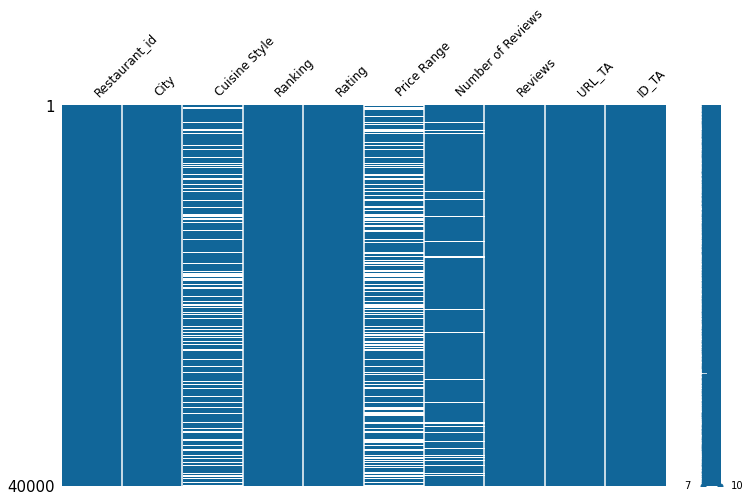

In [237]:
msno.matrix(df_main, figsize=(12, 7), fontsize=12, color=(0.07, 0.4, 0.6))

In [273]:
df_main.columns = [col.lower() for col in df_main.columns]
df_main.columns = [col.replace(' ', '_') for col in df_main.columns]

[К содержанию](#1)

---

# 2. Анализ и очистка переменных<a name="4"></a>

__Предсказваемая переменная - Rating__

count    40000.000000
mean         3.993037
std          0.668417
min          1.000000
25%          3.500000
50%          4.000000
75%          4.500000
max          5.000000
Name: rating, dtype: float64

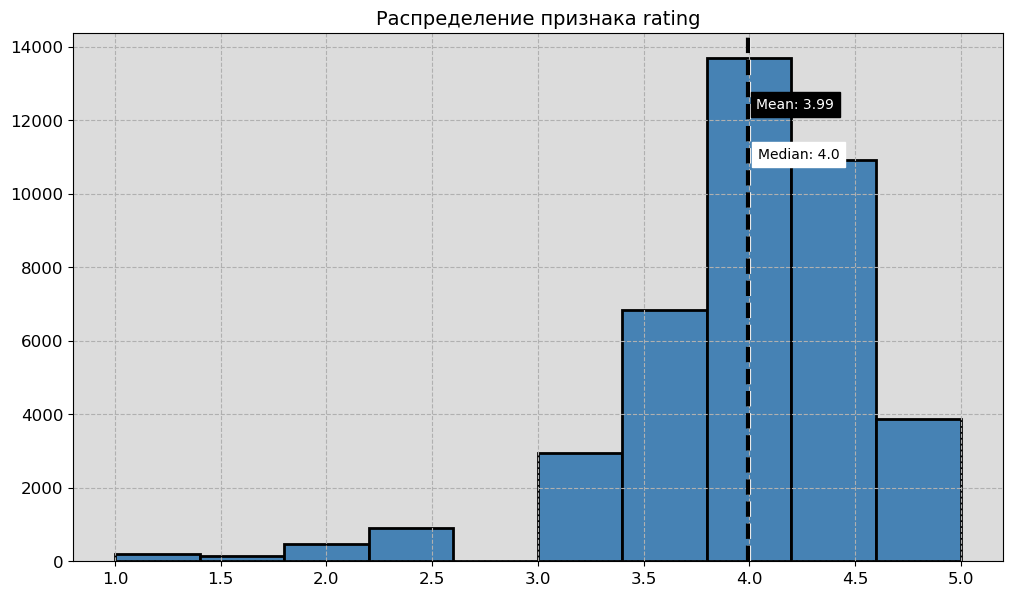

In [266]:
first_look(df_main, 'rating')

In [240]:
df_main['rating'].value_counts()

4.0    13692
4.5    10929
3.5     6824
5.0     3879
3.0     2955
2.5      915
2.0      466
1.0      201
1.5      139
Name: rating, dtype: int64

In [241]:
df_main['rating'].value_counts()

4.0    13692
4.5    10929
3.5     6824
5.0     3879
3.0     2955
2.5      915
2.0      466
1.0      201
1.5      139
Name: rating, dtype: int64

__Restaurant_id__

In [242]:
df_main['restaurant_id'].value_counts()

id_227      18
id_633      18
id_436      18
id_871      18
id_534      17
            ..
id_8234      1
id_11205     1
id_16145     1
id_12531     1
id_10431     1
Name: restaurant_id, Length: 11909, dtype: int64

In [243]:
df_main['restaurant_id'].nunique()

11909

__City__

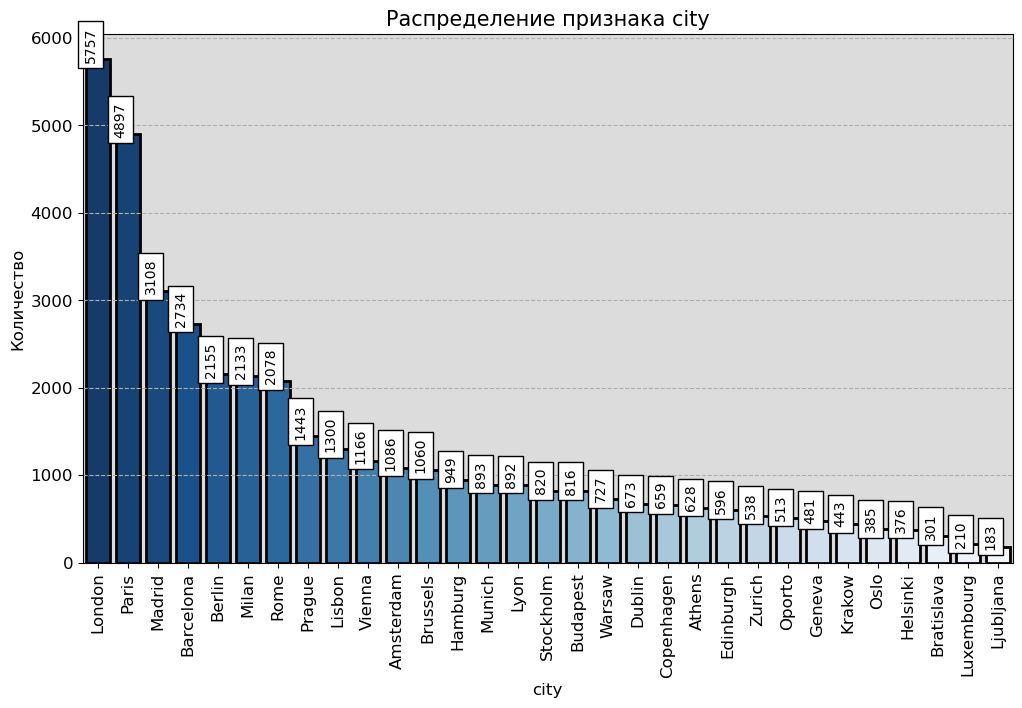

In [244]:
first_look(df_main, 'city')

In [245]:
df_main['city'] = df_main['city'].replace(['Oporto'], 'Porto')

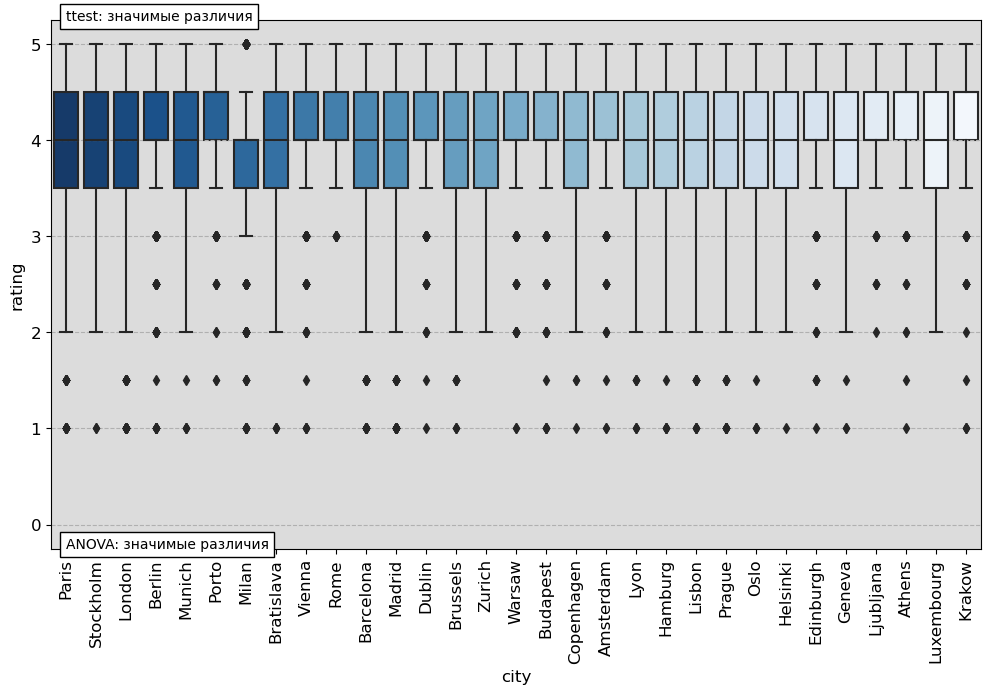

In [246]:
get_boxplot(df_main, 'city', 'rating')

__Cuisine Style__

In [247]:
pct_missing(df_main, 'cuisine_style')

Процент пропусков в столбце cuisine_style: 23.21


In [248]:
df_main['cuisine_style'].dropna()[0]

"['European', 'French', 'International']"

In [249]:
nan_column(df_main, 'cuisine_style')

In [250]:
df_main['cuisine_style'].fillna("['Other']", inplace=True)

In [251]:
df_main['cuisine_style'] = df_main['cuisine_style'].apply(lambda x: eval(x))

In [252]:
explode_cs = df_main.explode('cuisine_style')

In [253]:
explode_cs['cuisine_style'].nunique()-1

125

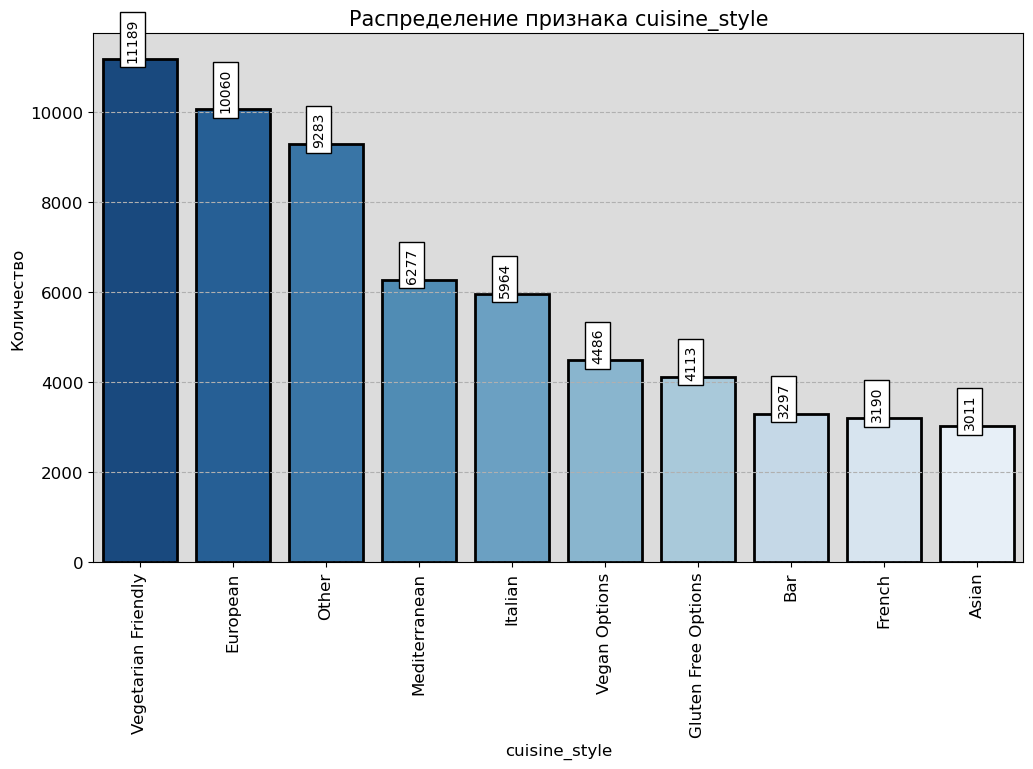

In [254]:
get_countplot_top_ten(explode_cs, 'cuisine_style')

__Ranking__

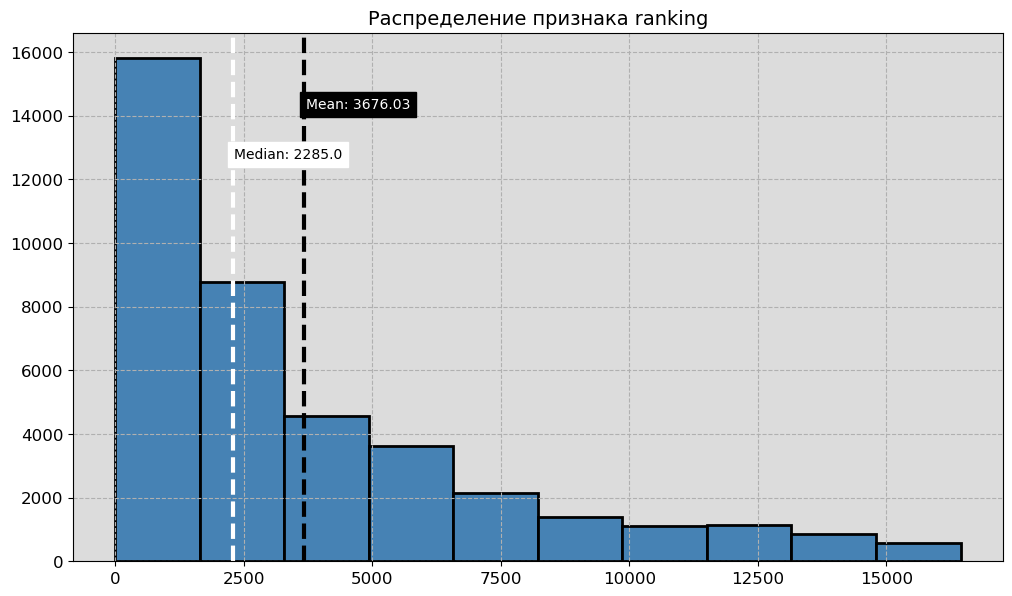

In [255]:
first_look(df_main, 'ranking')

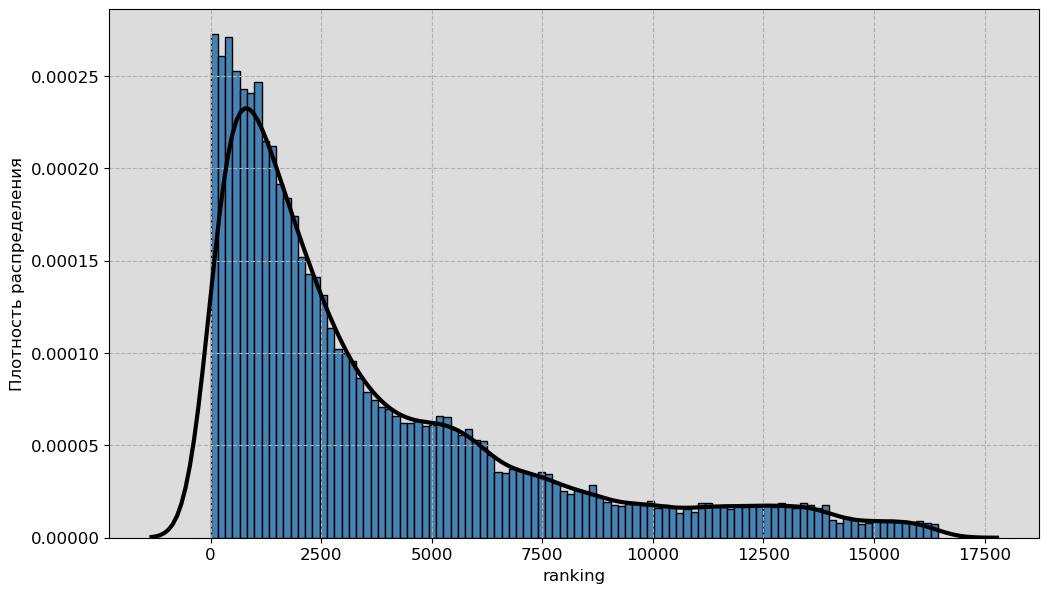

In [256]:
get_distplot(df_main, 'ranking')

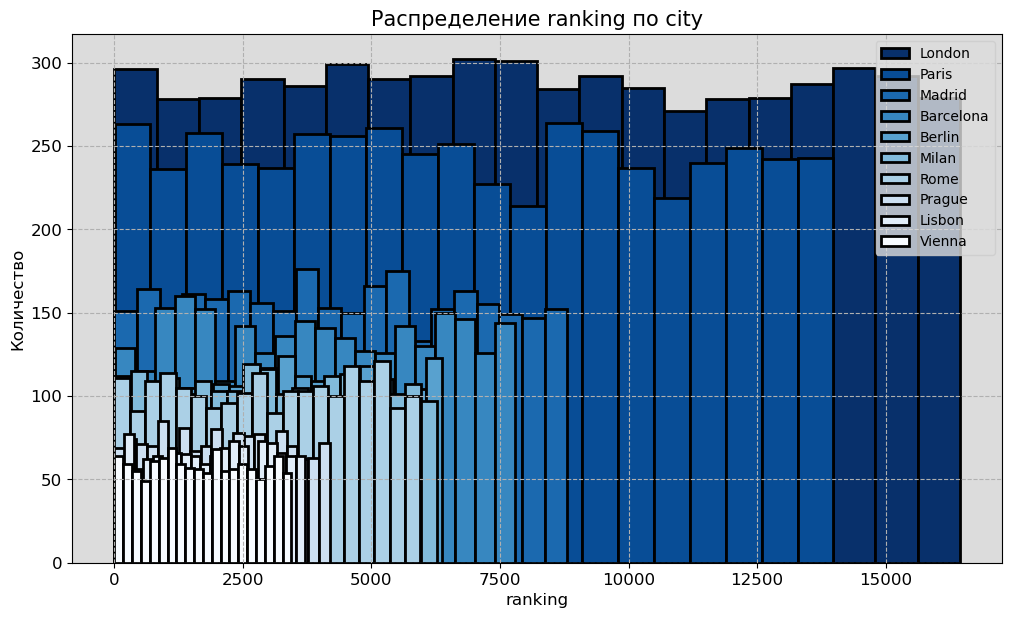

In [257]:
get_value_histogram_top_ten(df_main, 'ranking', 'city')

----------------
Корреляция: -0.37
----------------


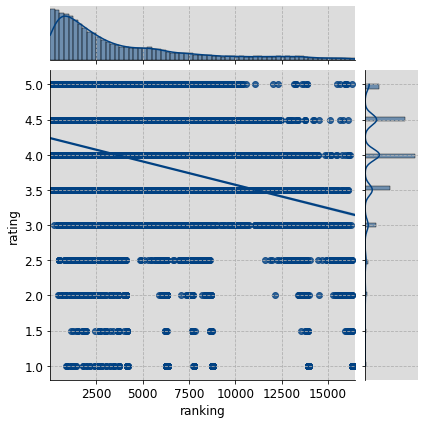

In [258]:
get_jointplot(df_main, 'ranking', 'rating')

__Price Range__

In [260]:
df_main[df_main['price_range'] == '$$ - $$$'].shape

(18412, 11)

In [ ]:
pct_missing(df_main, 'price_range')

In [ ]:
nan_column(df_main, 'price_range')

In [ ]:
price_ranges = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
df_main['price_range'] = df_main['price_range'].dropna().map(price_ranges)

In [ ]:
get_boxplot(df_main, 'price_range', 'rating')

In [ ]:
df_main['price_range'].fillna(df_main['price_range'].mode()[0], inplace=True)

__Reviews__

In [ ]:
df_main['reviews'].value_counts()[:5]

In [ ]:
df_main['empty_reviews'] = (df_main['reviews']=='[[], []]').astype('float64')

In [ ]:
df_main['reviews'] = df_main['reviews'].apply(
    lambda x: eval(x.replace('nan', '').replace('[,', "['',")))

In [ ]:
df_main['reviews'] = df_main['reviews'].apply(
    lambda x: np.nan if len(x[0]) == 0 & len(x[1]) == 0 else x)

In [ ]:
pct_missing(df_main, 'reviews')

__Number of Reviews__

In [ ]:
pct_missing(df_main, 'number_of_reviews')

In [ ]:
nan_column(df_main, 'number_of_reviews')

In [ ]:
df_main['len_last_reviews'] = df_main['reviews'].apply(lambda x: 0 if x != x else len(x[0]))

In [ ]:
df_main['number_of_reviews'] = df_main[['number_of_reviews', 'len_last_reviews']].apply(
    lambda x: x[1] if pd.isna(x[0]) else x[0], axis=1)

In [ ]:
get_distplot(df_main, 'number_of_reviews')

In [ ]:
iqr_filter(df_main, 'number_of_reviews')

In [ ]:
df_main['log_number_of_reviews'] = np.log(df_main['number_of_reviews'] + 1)

In [ ]:
get_distplot(df_main, 'log_number_of_reviews')

In [ ]:
iqr_filter(df_main, 'log_number_of_reviews')

In [ ]:
get_jointplot(df_main, 'number_of_reviews', 'rating')

__URL_TA__

In [ ]:
df_main['url_ta'][0]

In [ ]:
df_main.drop(['url_ta'], axis=1, inplace=True)

__ID_TA__

In [ ]:
df_main['id_ta'] = df_main['id_ta'].apply(lambda x:x[1:])

[К содержанию](#1)

---

# 3. Создание новых признаков<a name="5"></a>

In [ ]:
chain_lst = list(df_main['restaurant_id'].value_counts()[df_main['restaurant_id'].value_counts() > 1].index)

In [ ]:
df_main['chained'] = df_main[df_main['restaurant_id'].isin(chain_lst)]['restaurant_id'].apply(lambda x: 1)
df_main['chained'].fillna(0, inplace=True)

In [ ]:
city_lst = df_main['city'].unique()

In [ ]:
df_cities = df_cities[(df_cities['city_ascii'].isin(city_lst))&
                      (df_cities['lng'] > -11)&
                      (df_cities['lng'] < 40)]

In [ ]:
df_cities = df_cities.drop(['city', 'lat', 'lng','iso2', 'iso3', 'admin_name',  'id'], axis=1)

In [ ]:
df_cities['capital'] = df_cities['capital'].apply(lambda x: 1 if x == 'primary' else 0)

In [ ]:
df_main = df_main.join(df_cities.set_index('city_ascii'), on='city')

In [ ]:
df_main['cuisine_count'] = df_main['cuisine_style'].apply(lambda x: len(x))

In [ ]:
df_main['country'].unique()

In [272]:
df_main['cuisine_style'] = df_main['cuisine_style'].fillna("['Other']")

KeyError: 'cuisine_style'

In [274]:
le = LabelEncoder()
le.fit(df_main['cuisine_style'])
df_main['code_cuisine_style'] = le.transform(df_main['cuisine_style'])

In [276]:
df_main['code_cuisine_style'].value_counts()

9007    9283
6459    1032
4377     805
8496     695
4170     405
        ... 
6089       1
1963       1
4010       1
6057       1
2047       1
Name: code_cuisine_style, Length: 9008, dtype: int64

In [277]:
df_main['cuisine_style'].value_counts()

['Italian']                                                                              1032
['French']                                                                                805
['Spanish']                                                                               695
['French', 'European']                                                                    405
['Cafe']                                                                                  403
                                                                                         ... 
['American', 'Chinese', 'Fast Food', 'Asian', 'Vegetarian Friendly', 'Vegan Options']       1
['Italian', 'European', 'Bar', 'Vegetarian Friendly']                                       1
['Steakhouse', 'Brazilian', 'Latin', 'Barbecue', 'Grill', 'South American']                 1
['International', 'Mediterranean', 'French', 'Spanish']                                     1
['European', 'Portuguese', 'Mediterranean', 'Wine Bar']     

[К содержанию](#1)

---